In [1]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import torch
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
import numpy as np
sns.set()

In [2]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
model.to("cuda").eval();

In [3]:
data = pd.read_csv("../data/dataset_reduced_filtered_super_mega.csv")[["question", "answer"]].dropna()
questions = data["question"].values.tolist()

In [4]:
tokenized_questions = tokenizer(questions, return_tensors="pt", padding=True, truncation=True, max_length=100)

In [5]:
# токенайзер добавляет к каждому предложению токен [CLS] - это типо эмбеддинг всего предложения
# выдаст [num_texts, num_tokens, 768] - нужно взять 0 токен это наш эмбединг
with torch.no_grad():
    out = []

    ds = torch.utils.data.TensorDataset(tokenized_questions["input_ids"], 
                                        tokenized_questions["token_type_ids"], 
                                        tokenized_questions["attention_mask"])
    dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=6, pin_memory=True)

    for batch in tqdm(dl):
        input_ids, token_type_ids, attention_mask = map(lambda x: x.to("cuda"), batch)
        model_dict = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        out.append(model_dict["last_hidden_state"][:, 0, :].to("cpu"))

embeddings = torch.cat(out)
torch.save(embeddings, "text_embeddings.pt")
del model

  0%|          | 0/5444 [00:00<?, ?it/s]

In [7]:
kmeans = MiniBatchKMeans(n_clusters=150, batch_size=20000, random_state=42, max_no_improvement=25)
kmeans.fit(embeddings)
with open("kmeans.pkl", "wb") as km:
    pickle.dump(kmeans, km)

In [8]:
reducer2 = umap.UMAP(n_components=2, random_state=42)
X_ = reducer2.fit_transform(embeddings)

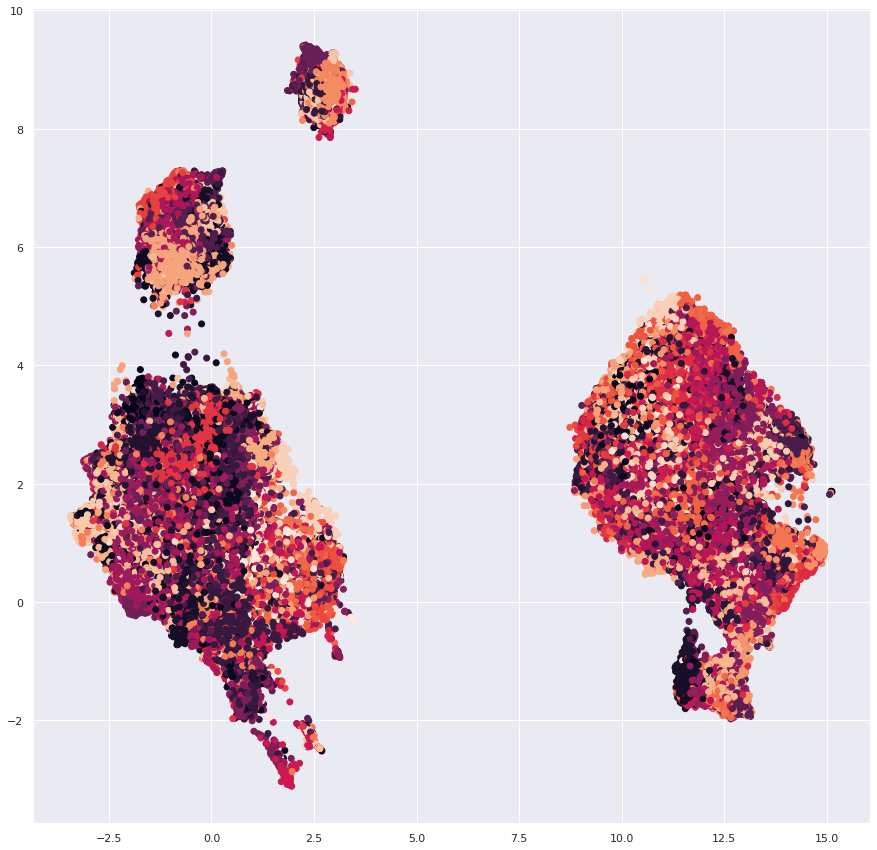

In [9]:
cluster_ids = kmeans.predict(embeddings)

plt.figure(figsize=(15, 15))
plt.scatter(X_[:, 0], 
            X_[:, 1], 
            c=cluster_ids)
plt.show()

In [10]:
new_data = data.copy()
new_data["cluster_id"] = cluster_ids
new_data.sort_values("cluster_id", inplace=True)

new_data.to_csv("question_cluster.csv", index=False)

In [11]:
test = pd.read_csv("question_cluster.csv")